# Example 2: Cloud Analysis on MDOF System

## Introduction

This Jupyter Notebook provides a structured workflow for performing a nonlinear time-history analyses (NLTHA), namely cloud analysis on multi-degree-of-freedom (MDOF) structural models using natural unscaled ground-motion records. By combining functions for MDOF calibration, modeling and dynamic analysis, the notebook enables the setup, execution, and post-processing of structural responses under earthquake loading.

The main goals of this notebook:

1. **Calibrate MDOF models based on single-degree-of-freedom (SDOF) oscillator capacity**: Calibrate storey-based force-deformation relationships using SDOF capacity curve definition (spectral displacement-spectral acceleration) based on the methodology of Lu et al. (2020) and other modifications to account for distinct response typologies (i.e., bilinear, trilinear and quadrilinear backbone definitions)

2. **Compile and construct MDOF Models in OpenSees**: Define and assemble MDOF models by specifying essential structural properties, including mass, heights, fundamental period and nonlinear response characteristics at each degree of freedom

3. **Run Nonlinear Time-History Analysis (NLTHA) in OpenSees**: Simulate the dynamic response of MDOF structures under time-dependent inputs, such as ground motion records, to realistically assess structural behavior and response metrics (e.g., peak storey drifts, peak floor accelerations) under loading conditions and extract critical response metrics and model information.

4. **Fragility Analysis**: Postprocess cloud analysis results to fit a probabilistic seismic demand model (PSDM) to ultimately estimate the median seismic intensities and total dispersion associated with arbitrary demand-based thresholds (i.e., maximum interstorey drift-based) and construct the fragility functions relating damage state exceedance probabilities with increasing levels of ground-shaking.

5. **Vulnerability Analysis**: Integrate fragility functions with consequence models (i.e., damage-to-loss models) to determine the continuous relationship between a decision variable and increasing levels of ground-shaking.


The notebook provides a step-by-step guide, covering each phase from MDOF model calibration, setup to input parameter configuration, analysis execution, and detailed results extraction and postprocessing. Users should have some familiarity with python scripts, structural dynamics, computational modeling, and performance-based earthquake engineering to fully benefit from this material.

---

## References

[1] Jalayer F, Ebrahimian H, Miano A, Manfredi G, Sezen H. Analytical fragility assessment using unscaled ground motion records. Earthquake Engng Struct Dyn. 2017; 46: 2639–2663. https://doi.org/10.1002/eqe.2922

[2] Lu X, McKenna F, Cheng Q, Xu Z, Zeng X, Mahin SA. An open-source framework for regional earthquake loss estimation using the city-scale nonlinear time history analysis. Earthquake Spectra. 2020;36(2):806-831. doi:10.1177/8755293019891724

## Initialize Libraries ##

In [1]:
import os
import sys
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import the classes necessary for structural analysis
from openquake.vmtk.units         import units              # oq-vtmk units class
from openquake.vmtk.calibration   import calibrate_model    # oq-vmtk sdof-to-mdof calibration class
from openquake.vmtk.modeller      import modeller           # oq-vmtk numerical modelling class
from openquake.vmtk.postprocessor import postprocessor      # oq-vtmk postprocessing class
from openquake.vmtk.plotter       import plotter            # oq-vmtk plotting class
from openquake.vmtk.utilities     import sorted_alphanumeric, import_from_pkl, export_to_pkl # oq-vmtk utility class

## Define Directories ##

In [2]:
# Define the directory of the ground-motion records
gm_directory  = './records'            

# Define the main output directory
nrha_directory = './output'  
os.makedirs(nrha_directory, exist_ok=True)

# Define directory for temporary analysis outputs: it is used to store temporary .txt files used as accelerations recorders
temp_nrha_directory = os.path.join(nrha_directory,'temp')
os.makedirs(temp_nrha_directory, exist_ok=True)

## Import Analysis Data ##

In [3]:
# Import the intensity measure dictionary (output from example 1)
ims           = import_from_pkl(os.path.join(gm_directory, 'imls_esrm20.pkl'))  

## Required Input Parameters ##

### Modelling Input Parameters ###

In [4]:
# Number of storeys
number_storeys = 2

# Relative floor heights list
floor_heights = [2.80, 2.80]

# First-mode based participation factor
gamma = 1.33

# SDOF capacity (First row are Spectral Displacement [m] values - Second row are Spectral Acceleration [g] values)
sdof_capacity = np.array([[0.00060789, 0.00486316, 0.02420000, 0.04353684], 
                          [0.10315200, 0.20630401, 0.12378241, 0.12502023]]).T
# Frame flag
isFrame = False

# Soft-storey mechanism flag
isSOS = False

# Degradation flag 
mdof_degradation = True

# Inherent damping 
mdof_damping = 0.05

### Fragility and Vulnerability Input Parameters ###

In [5]:
# Intensity measures to use for postprocessing cloud analyses
IMTs      = ['PGA', 'SA(0.3s)', 'SA(0.6s)', 'SA(1.0s)','AvgSA']

# Damage thresholds (maximum peak storey drift values in rad)
damage_thresholds    =  [0.00150, 0.00545, 0.00952, 0.0135] 

# The lower limit to be applied for censoring edp values (below 0.1 the minimum threshold for slight damage is considered a negligible case)
lower_limit = 0.1*damage_thresholds[0]

# The upper limit to be applied for consoring edp values (above 1.5 the maximum threshold is considered a collapse case) 
censored_limit = 1.5*damage_thresholds[-1]   

# Define consequence model to relate structural damage to a decision variable (i.e., expected loss ratio) 
consequence_model = [0.05, 0.20, 0.60, 1.00] # damage-to-loss ratios

## Cloud Analysis ##

Cloud Analysis is a method used in structural engineering to assess the fragility of structures under seismic events. It involves performing nonlinear dynamic analyses using a set of recorded ground motions without scaling them, and then applying simple linear regression in the logarithmic space of structural response versus seismic intensity. This approach allows for efficient estimation of structural fragility by considering the inherent variability in ground motions.

### Cloud Analysis - Part 1: Calibrate MDOF Model based on SDOF Capacity Definition ###

#### The calibration function (calibrate_model) requires five input arguments:
1. Number of storeys
2. First-mode transformation factor (gamma)
3. The capacity array of the single degree-of-freedom oscillator
4. Boolean flag whether the lateral load-resisting system for the considered building class is moment-resisting frames or braced frames (or not)
5. Boolean flag whether the building class expects a soft-storey mechanism to be activated (or not)
#### The calibration function (calibrate_model) returns four output variables:
1. The floor mass array to be assigned to the MDOF model generator (floor_masses)
2. The storey deformation (in m) capacity to be assigned to the MDOF model generator (storey_disps)
3. The acceleration capacity (in g) to be assigned to the MDOF model generator (storey_forces)
4. The considered mode shape (mdof_phi)

The mass of each floor (in tonnes): [0.5979496788391293, 0.448462259129347]
The first-mode shape used for calibration: [0.65138782 1.        ]


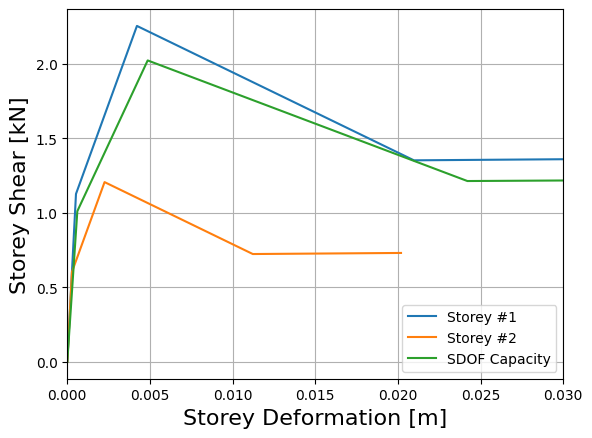

In [6]:
# Calibrate the model using the Lu et al. (2020) method
floor_masses, storey_disps, storey_forces, mdof_phi = calibrate_model(number_storeys, gamma, sdof_capacity, isFrame, isSOS)

print('The mass of each floor (in tonnes):', floor_masses)
print('The first-mode shape used for calibration:', mdof_phi)

# Plot the capacities to visualise the outcome of the calibration
for i in range(storey_disps.shape[0]):
   plt.plot(np.concatenate(([0.0], storey_disps[i,:])), np.concatenate(([0.0], storey_forces[i,:]*9.81)), label = f'Storey #{i+1}')
plt.plot(np.concatenate(([0.0], sdof_capacity[:,0])), np.concatenate(([0.0], sdof_capacity[:,1]*9.81)), label = 'SDOF Capacity')
plt.xlabel('Storey Deformation [m]', fontsize= 16)
plt.ylabel('Storey Shear [kN]', fontsize = 16)
plt.legend(loc = 'lower right')
plt.grid(visible=True, which='major')
plt.grid(visible=True, which='minor')
plt.xlim([0.00, 0.03])
plt.show()

### Cloud Analysis - Part 2: Setting Up, Running and Exporting Analysis ###

============== Analysing: 1 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


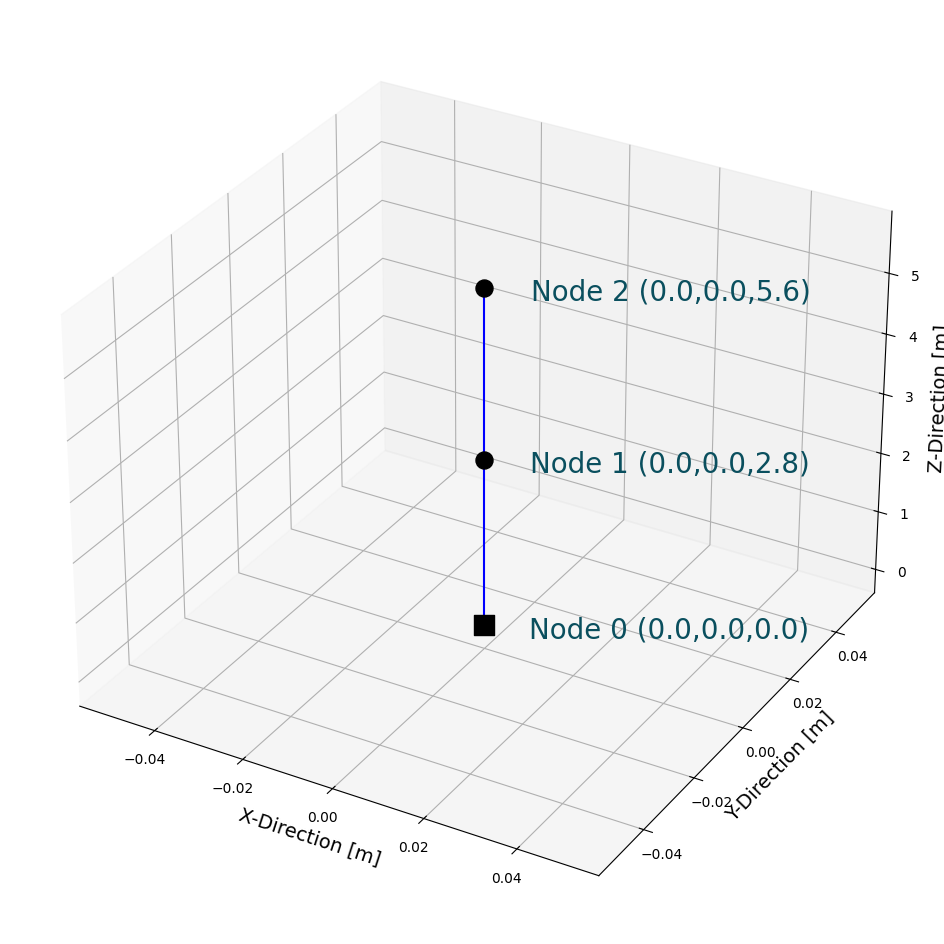

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 2 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 3 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 4 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 5 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 6 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 7 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 8 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 9 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 10 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 11 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 12 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 13 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 14 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 15 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 16 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 17 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 18 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 19 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 20 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 21 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 22 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 23 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 24 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 25 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 26 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 27 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 28 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 29 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 30 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 31 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 32 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 33 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 34 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 35 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 36 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 37 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 38 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 39 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 40 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 41 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 42 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 43 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 44 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 45 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 46 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 47 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 48 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 49 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 50 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 51 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 52 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 53 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 54 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 55 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 56 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 57 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 58 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 59 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 60 out of 200 ==================
~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 61 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 62 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 63 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 64 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 65 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 66 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 67 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 68 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 69 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 70 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 71 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 72 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 73 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 74 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 75 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 76 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 77 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 78 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 79 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 80 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 81 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 82 out of 200 ==================
~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 83 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 84 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 85 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 86 out of 200 ==================
~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 87 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 88 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 89 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 90 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 91 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 92 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 93 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 94 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 95 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 96 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 97 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 98 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 99 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 100 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 101 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 102 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 103 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 104 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 105 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 106 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 107 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 108 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 109 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 110 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 111 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 112 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 113 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 114 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 115 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 116 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 117 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 118 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 119 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 120 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 121 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 122 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 123 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 124 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 125 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 126 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 127 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 128 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 129 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 130 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 131 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 132 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 133 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 134 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 135 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 136 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 137 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 138 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 139 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 140 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 141 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 142 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 143 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 144 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 145 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 146 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 147 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 148 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 149 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 150 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 151 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 152 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 153 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 154 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 155 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 156 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 157 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 158 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 159 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 160 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 161 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 162 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 163 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 164 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 165 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 166 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 167 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 168 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 169 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 170 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 171 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 172 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 173 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 174 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 175 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 176 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 177 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 178 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 179 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 180 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 181 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 182 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 183 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 184 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 185 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 186 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 187 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 188 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 189 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 190 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 191 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 192 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 193 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 194 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 195 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 196 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 197 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 198 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 199 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== Analysing: 200 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
ANALYSIS COMPLETED!


In [7]:
# Initialise MDOF storage lists
conv_index_list = []               # List for convergence indices
peak_disp_list  = []               # List for peak floor displacement (returns all peak values along the building height)
peak_drift_list = []               # List for peak storey drift (returns all peak values along the building height)
peak_accel_list = []               # List for peak floor acceleration (returns all peak values along the building height)
max_peak_drift_list = []           # List for maximum peak storey drift (returns the maximum value) 
max_peak_drift_dir_list = []       # List for maximum peak storey drift directions
max_peak_drift_loc_list = []       # List for maximum peak storey drift locations
max_peak_accel_list = []           # List for maximum peak floor acceleration (returns the maximum value)
max_peak_accel_dir_list = []       # List for maximum peak floor acceleration directions 
max_peak_accel_loc_list = []       # List for maximum peak floor acceleration locations

# Loop over ground-motion records, compile MDOF model and run NLTHA
gmrs = sorted_alphanumeric(os.listdir(os.path.join(gm_directory,'acc')))                         # Sort the ground-motion records alphanumerically
dts  = sorted_alphanumeric(os.listdir(os.path.join(gm_directory,'dts')))                         # Sort the ground-motion time-step files alphanumerically

# Run the analysis
for i in range(len(gmrs)):
    ### Print post-processing iteration
    print('================================================================')
    print('============== Analysing: {:d} out of {:d} =================='.format(i+1, len(gmrs)))
    print('================================================================')

    ### Compile the MDOF model    
    model = modeller(number_storeys,
                     floor_heights,
                     floor_masses,
                     storey_disps,
                     storey_forces*units.g,
                     mdof_degradation)                                                                # Initialise the class (Build the model)
    
    model.compile_model()                                                                             # Compile the MDOF model
    
    if i==0:
        model.plot_model()                                                                            # Visualise the model (only on first iteration)        
    model.do_gravity_analysis()                                                                       # Do gravity analysis

    if number_storeys == 1:
        num_modes = 1
    else:
        num_modes = 3
    T, phi = model.do_modal_analysis(num_modes = num_modes)                                           # Do modal analysis and get period of vibration (Essential step for running NLTHA)

    ### Define ground motion objects
    fnames = [os.path.join(gm_directory,'acc',f'{gmrs[i]}')]                                          # Ground-motion record names
    fdts   =  os.path.join(gm_directory,'dts',f'{dts[i]}')                                            # Ground-motion time-step names 
    dt_gm = pd.read_csv(fdts, header=None)[pd.read_csv(fdts,header=None).columns[0]].loc[1]-\
            pd.read_csv(fdts, header=None)[pd.read_csv(fdts,header=None).columns[0]].loc[0]           # Ground-motion time-step
    t_max = pd.read_csv(fdts)[pd.read_csv(fdts).columns[0]].iloc[-1]                                  # Ground-motion duration
    
    ### Define analysis params and do NLTHA
    dt_ansys = dt_gm                                                            # Set the analysis time-step
    sf = units.g                                                                # Set the scaling factor (if records are in g, a scaling factor of 9.81 m/s2 must be used to be consistent with opensees) 
    control_nodes, conv_index, peak_drift, peak_accel, max_peak_drift, max_peak_drift_dir, max_peak_drift_loc, max_peak_accel, max_peak_accel_dir, max_peak_accel_loc, peak_disp = model.do_nrha_analysis(fnames, 
                                                                                                                                                                                                          dt_gm, 
                                                                                                                                                                                                          sf, 
                                                                                                                                                                                                          t_max, 
                                                                                                                                                                                                          dt_ansys,
                                                                                                                                                                                                          temp_nrha_directory,
                                                                                                                                                                                                          pflag=False,
                                                                                                                                                                                                          xi = mdof_damping)

    ### Store the analysis
    conv_index_list.append(conv_index)
    peak_drift_list.append(peak_drift)
    peak_accel_list.append(peak_accel)
    peak_disp_list.append(peak_disp)
    max_peak_drift_list.append(max_peak_drift)
    max_peak_drift_dir_list.append(max_peak_drift_dir)
    max_peak_drift_loc_list.append(max_peak_drift_loc)
    max_peak_accel_list.append(max_peak_accel)
    max_peak_accel_dir_list.append(max_peak_accel_dir)
    max_peak_accel_loc_list.append(max_peak_accel_loc)

# Remove the temporary directory
shutil.rmtree(f'{temp_nrha_directory}')

# Store the analysis results in a dictionary
ansys_dict = {}
labels = ['T','control_nodes', 'conv_index_list',
          'peak_drift_list','peak_accel_list',
          'max_peak_drift_list', 'max_peak_drift_dir_list', 
          'max_peak_drift_loc_list','max_peak_accel_list',
          'max_peak_accel_dir_list','max_peak_accel_loc_list',
          'peak_disp_list']

for i, label in enumerate(labels):
    ansys_dict[label] = vars()[f'{label}']
# Export the analysis output variable to a pickle file using the "export_to_pkl" function from "utilities"
export_to_pkl(os.path.join(nrha_directory,'ansys_out.pkl'), ansys_dict) 

print('ANALYSIS COMPLETED!')

### Cloud Analysis - Part 3: Constructing Fragility Functions ### 
#### The cloud analysis module (do_cloud_analysis) of the "postprocessor" class requires five mandatory arguments and one optional:
1. The intensity measure levels of the ground-motion records (imls)
2. The engineering demand parameters from the analysis (edps)
3. The demand-based damage thresholds (damage_thresholds)
4. The lower edp censoring limit (lower_limit)
5. The upper edp censoring limit (censored_limit)
6. OPTIONAL: The modelling uncertainty (sigma_build2build), default is set 0.3

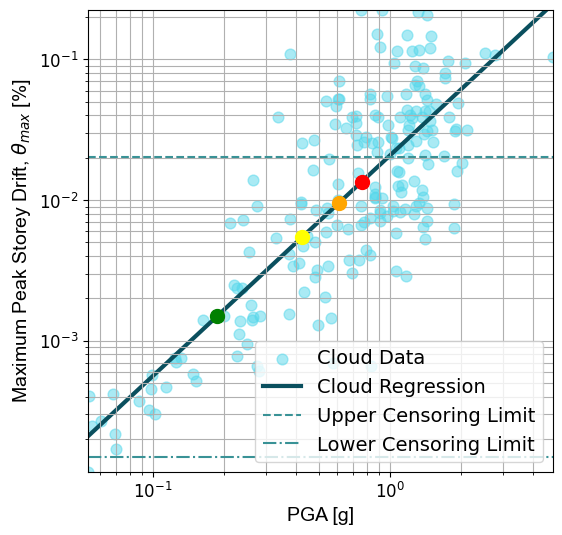

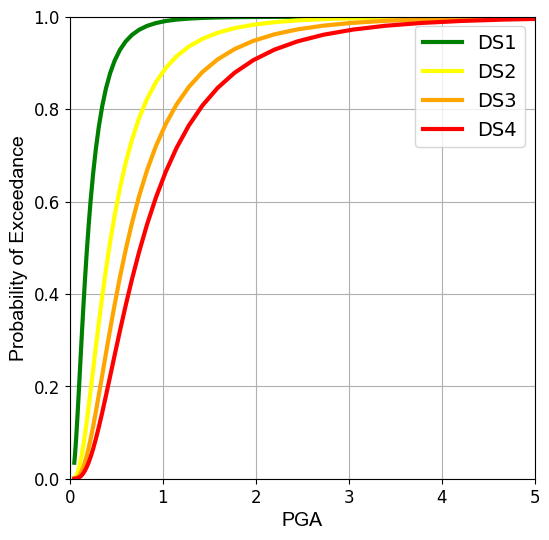

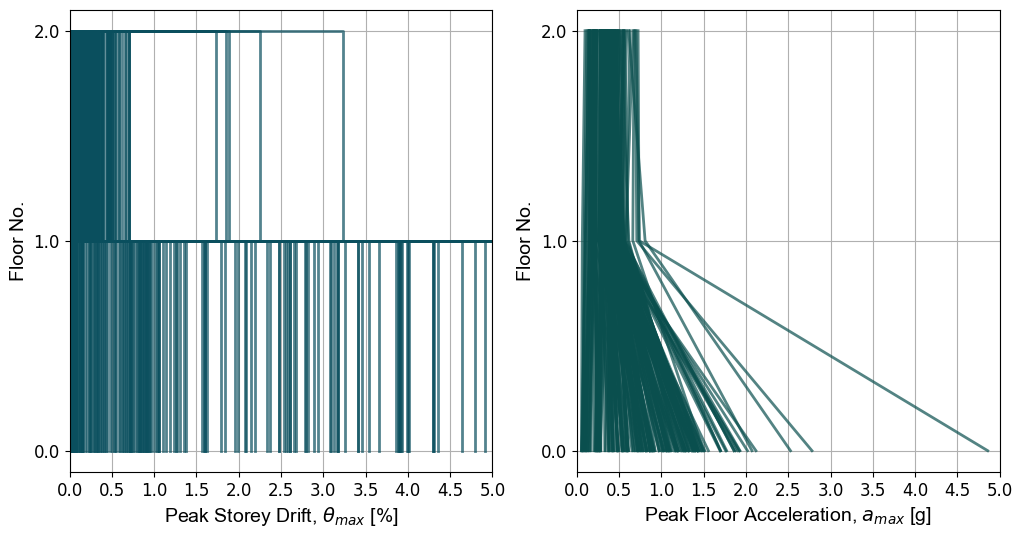

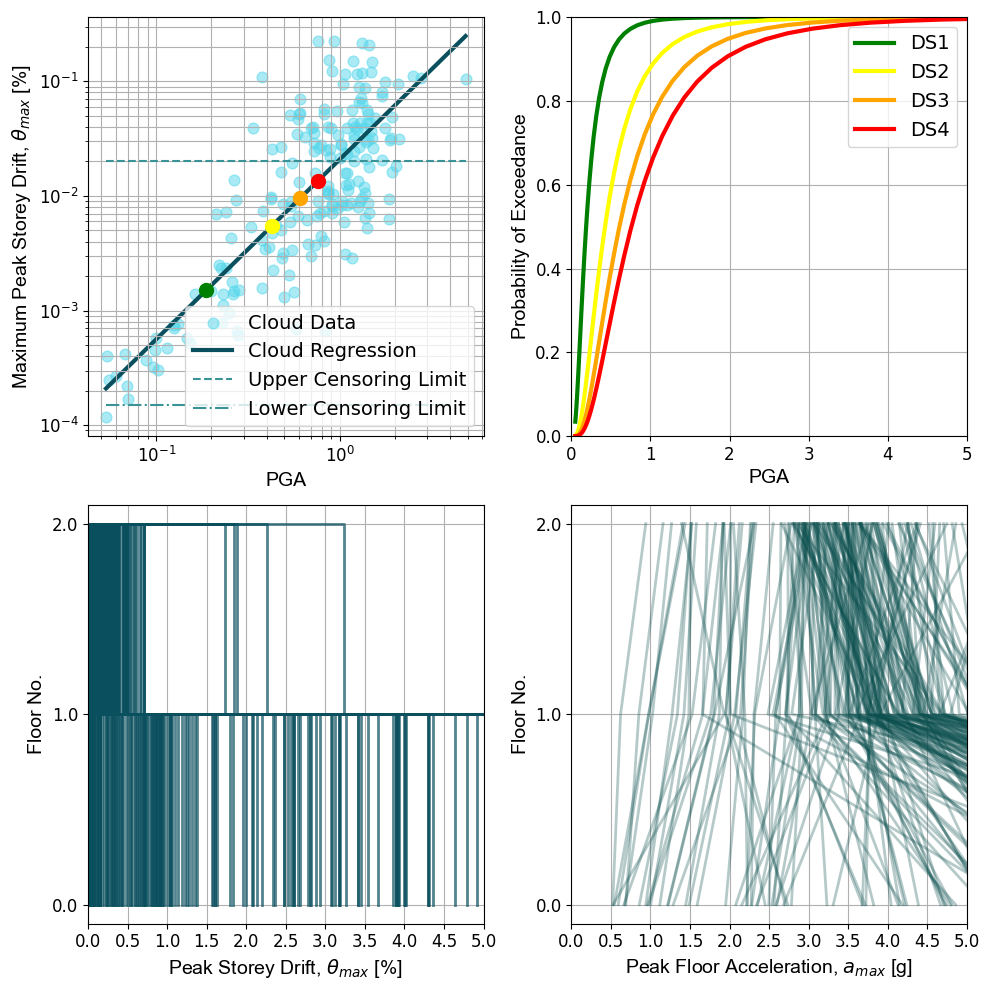

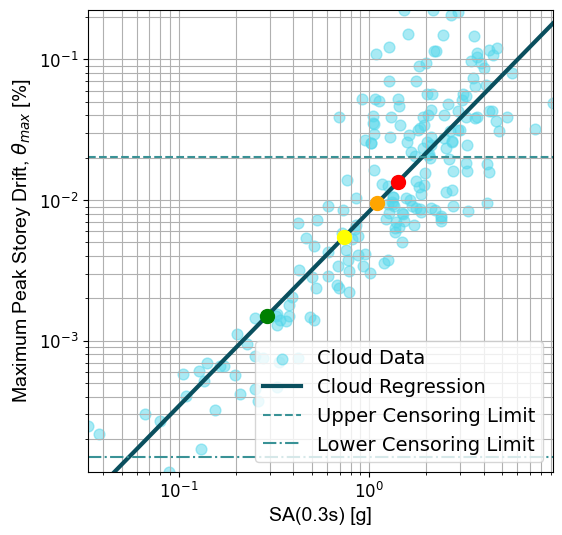

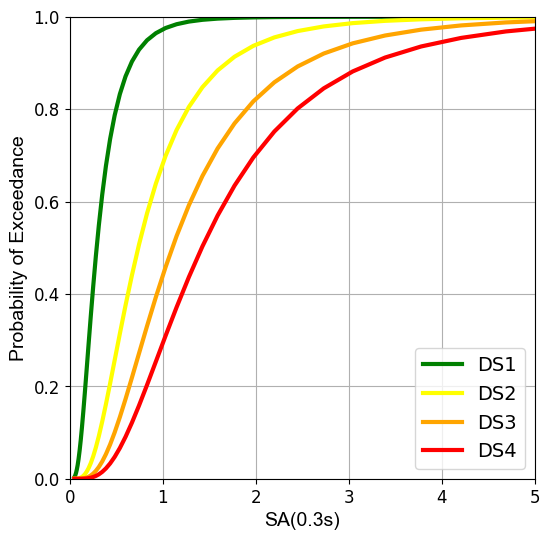

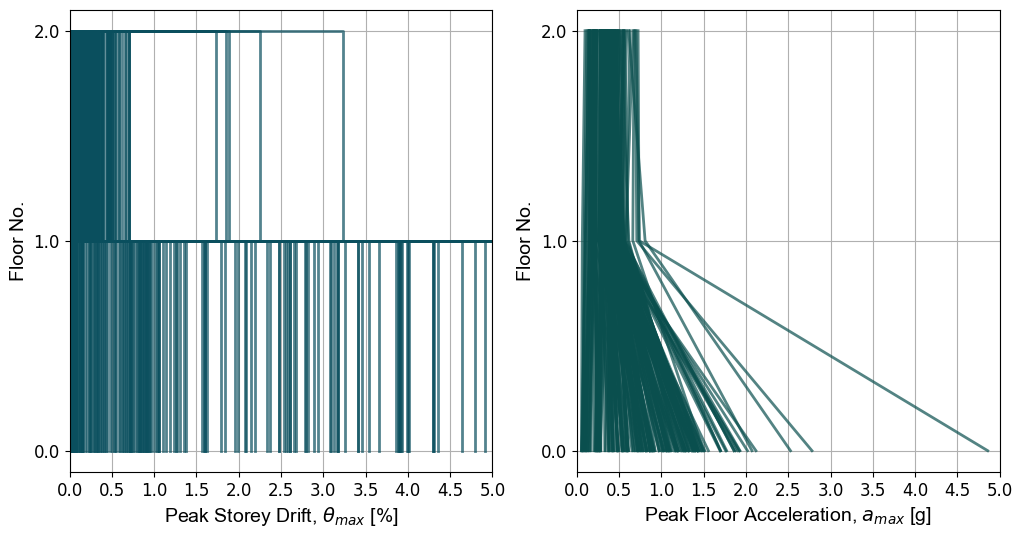

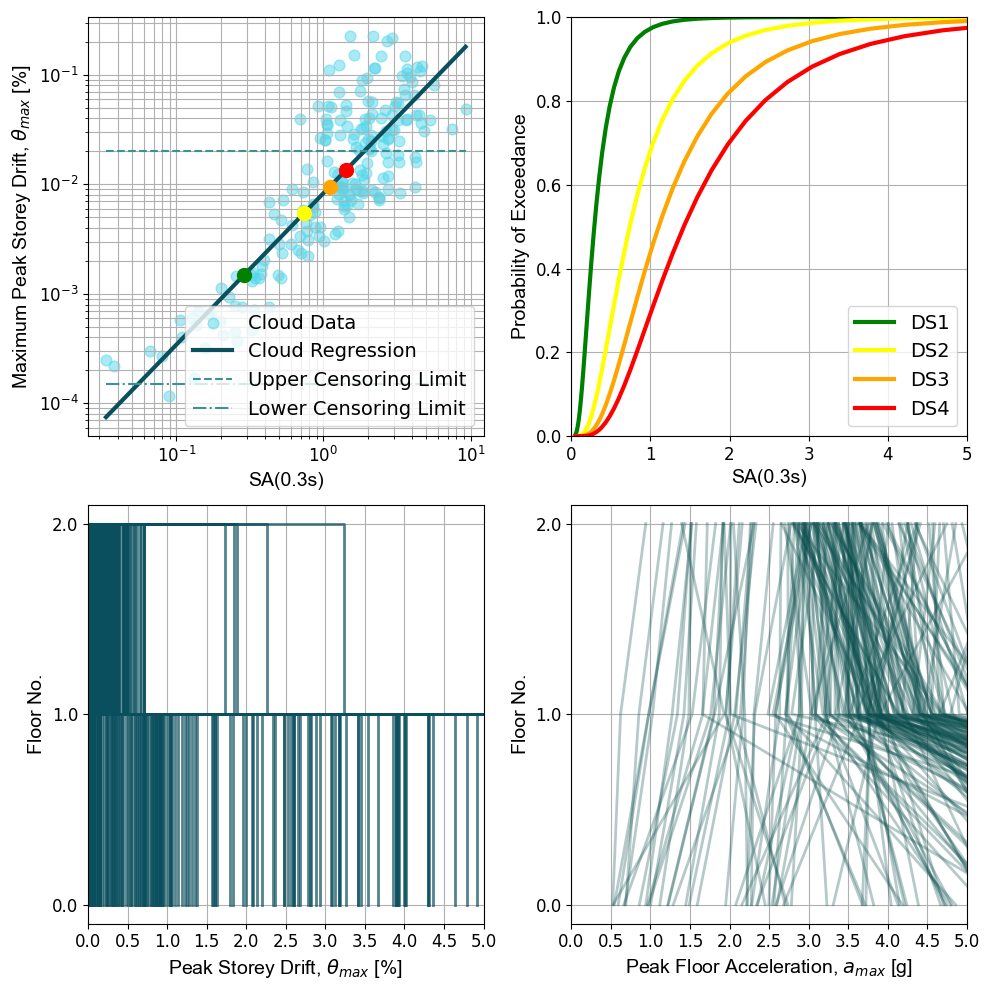

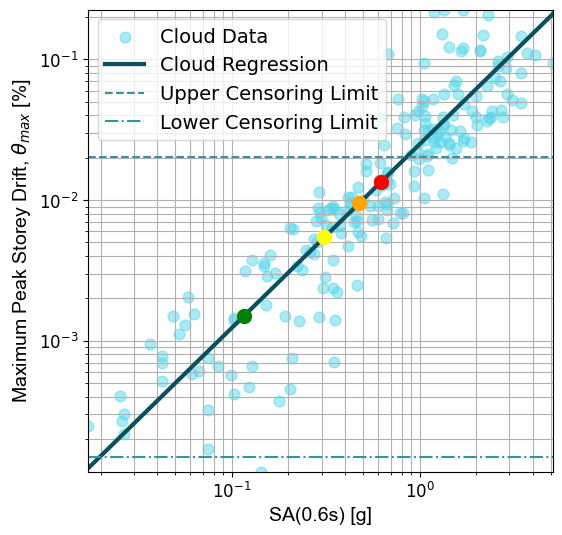

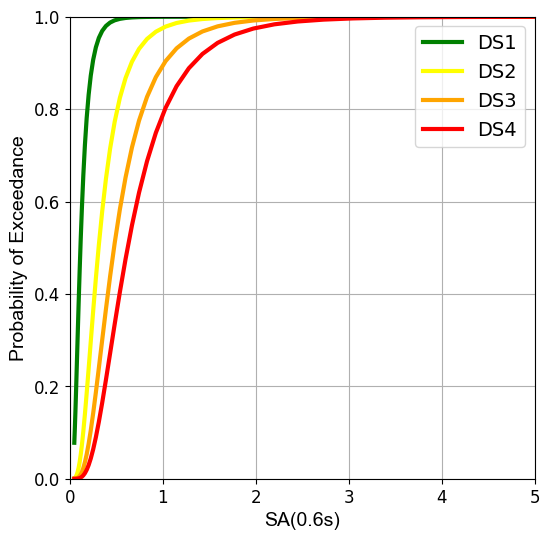

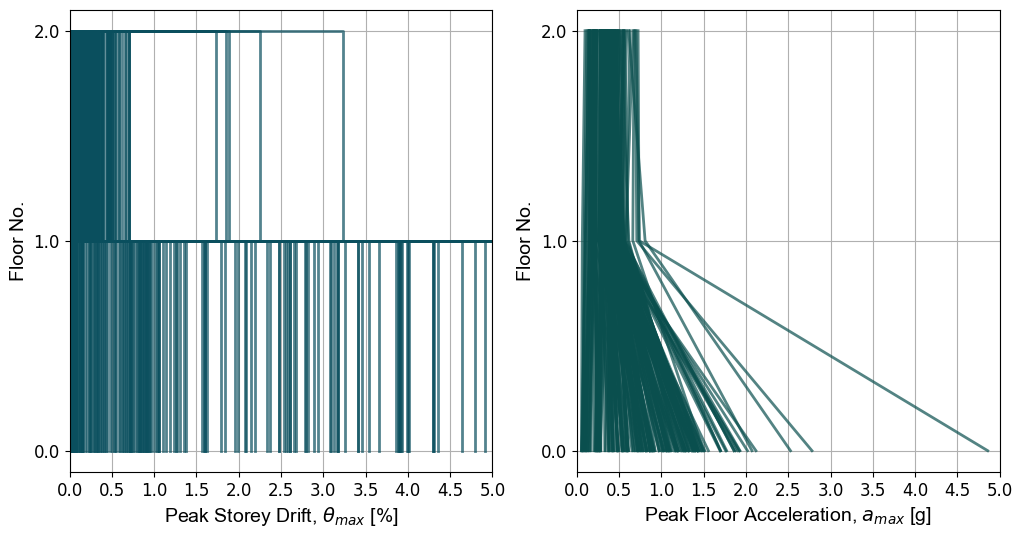

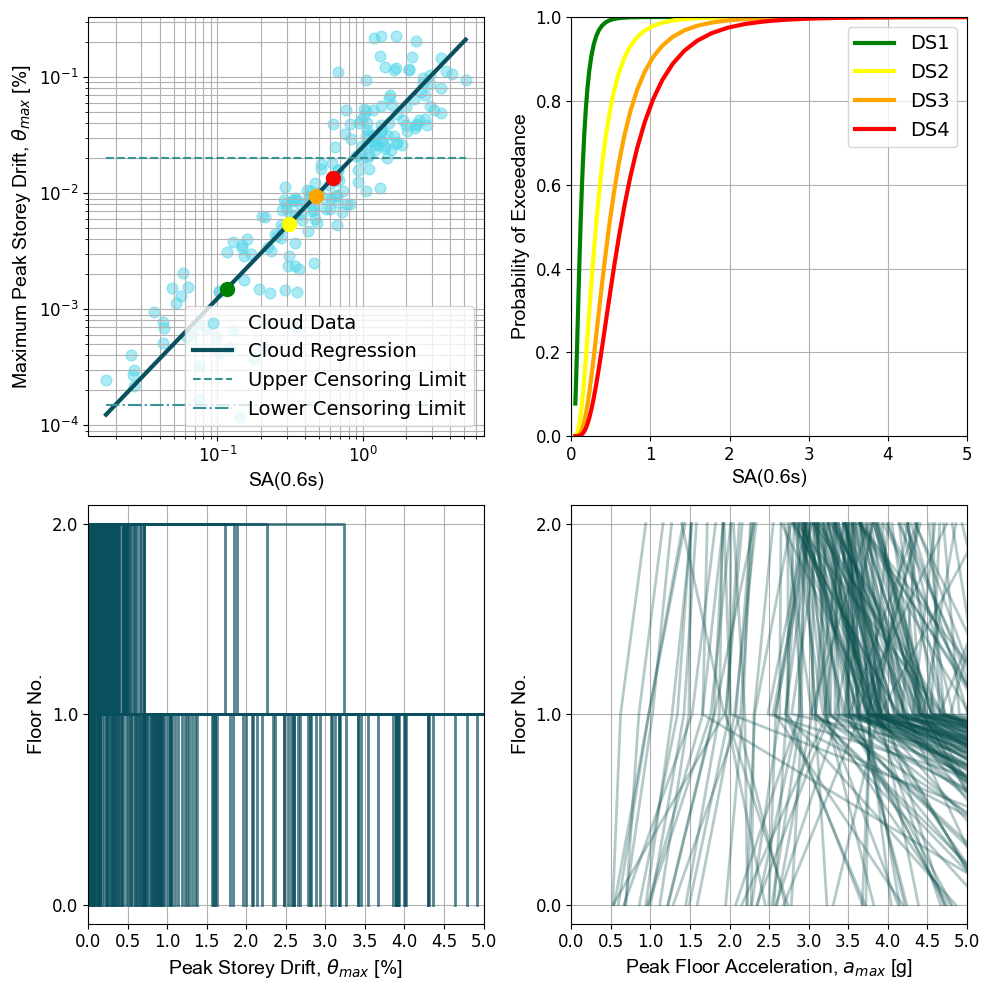

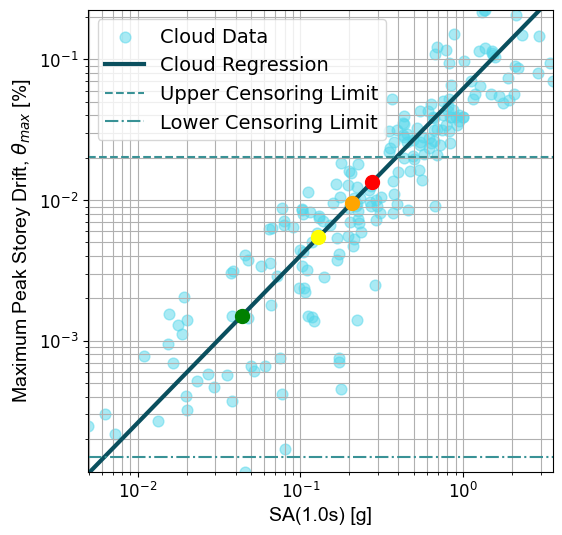

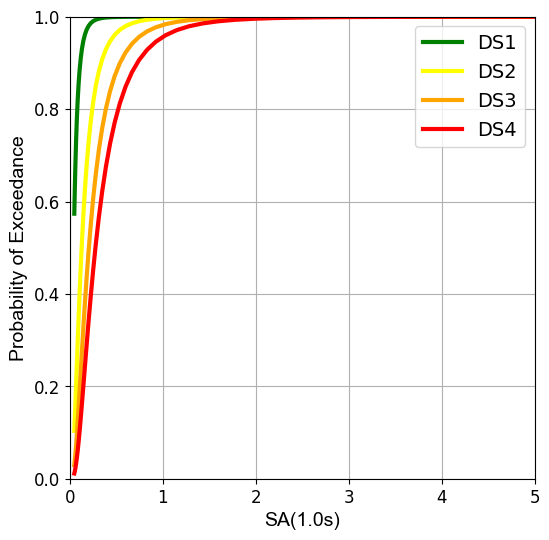

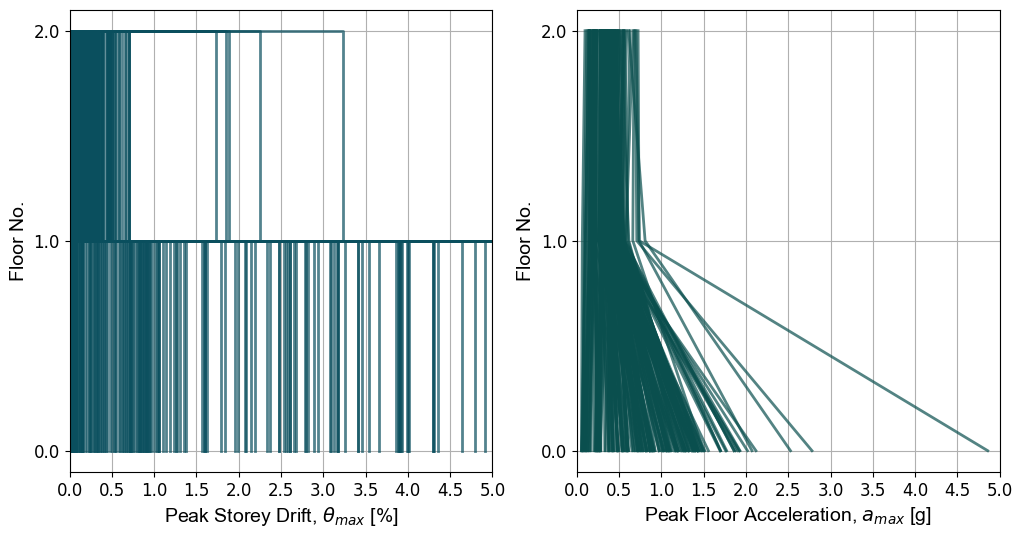

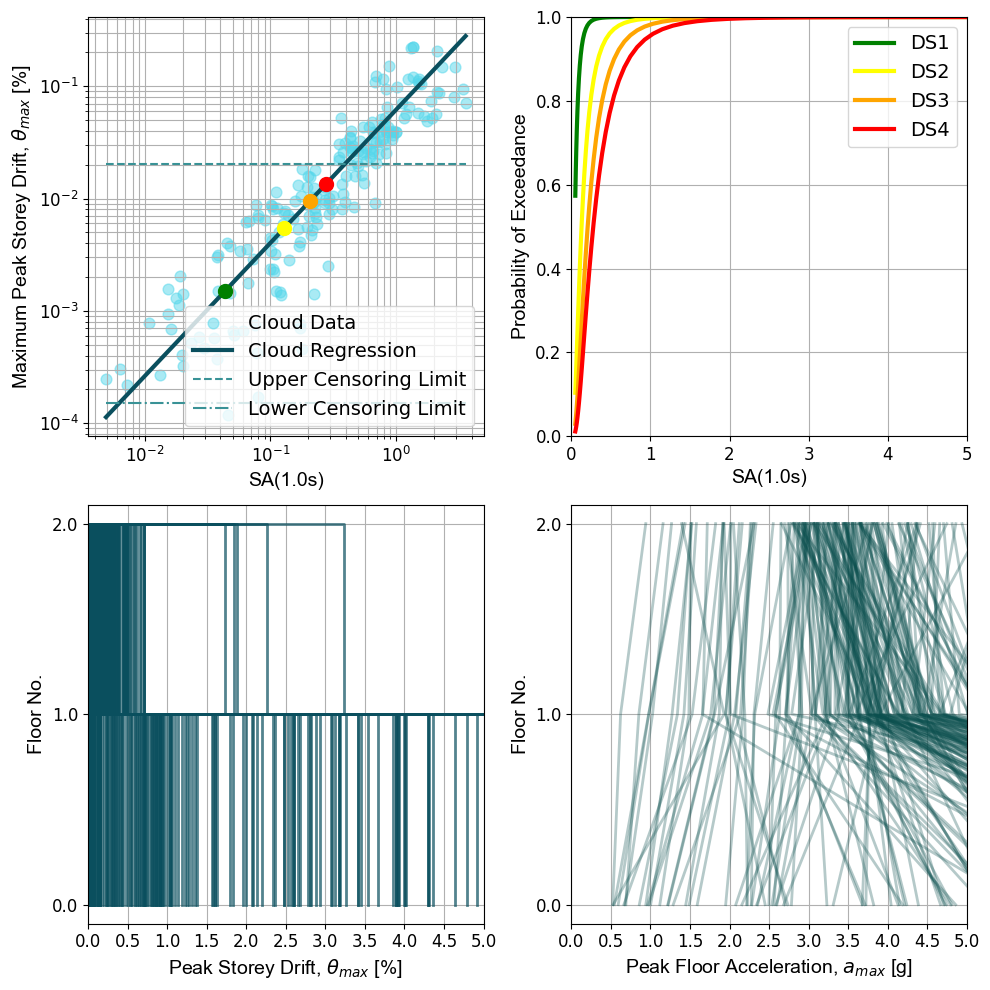

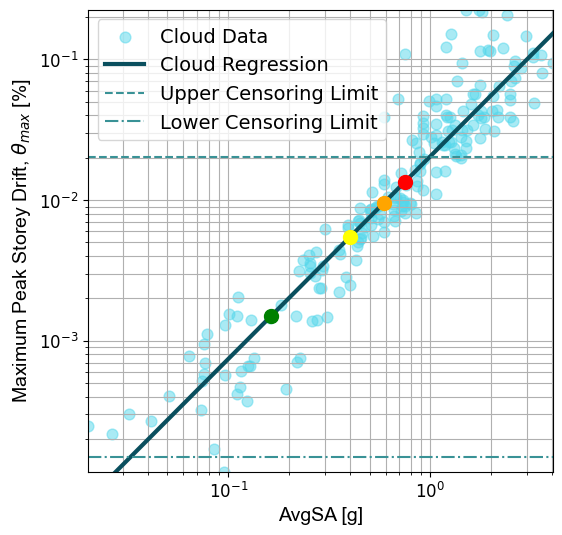

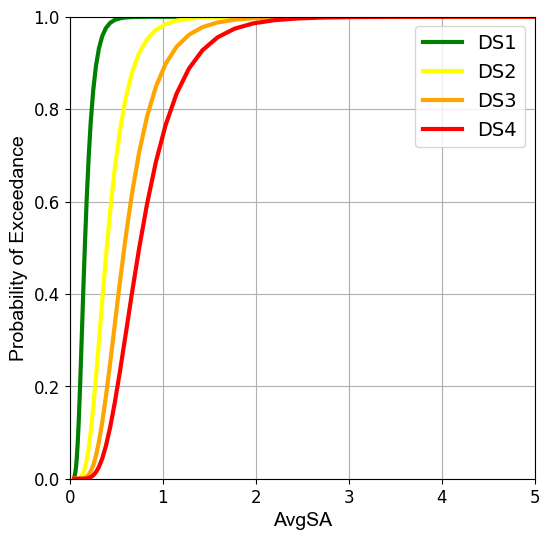

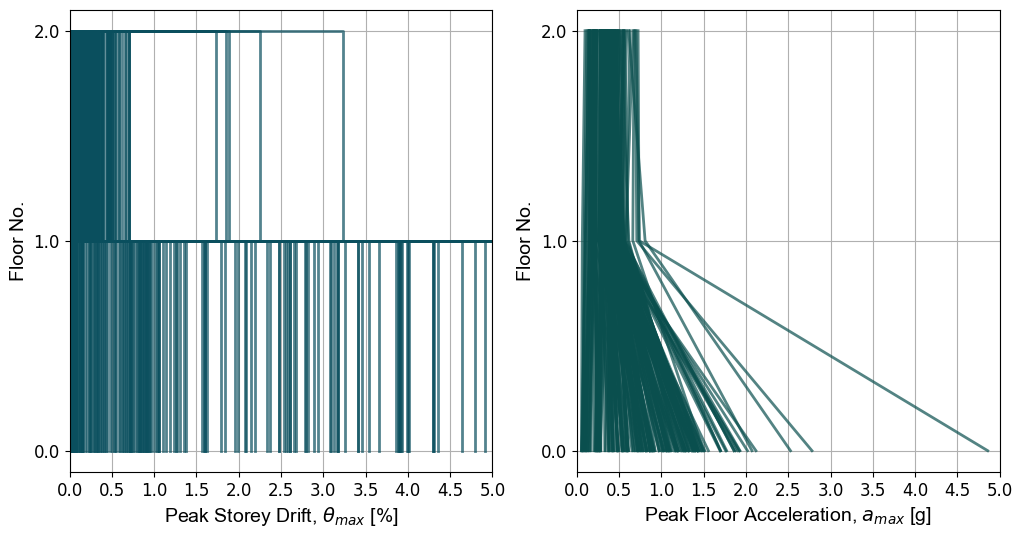

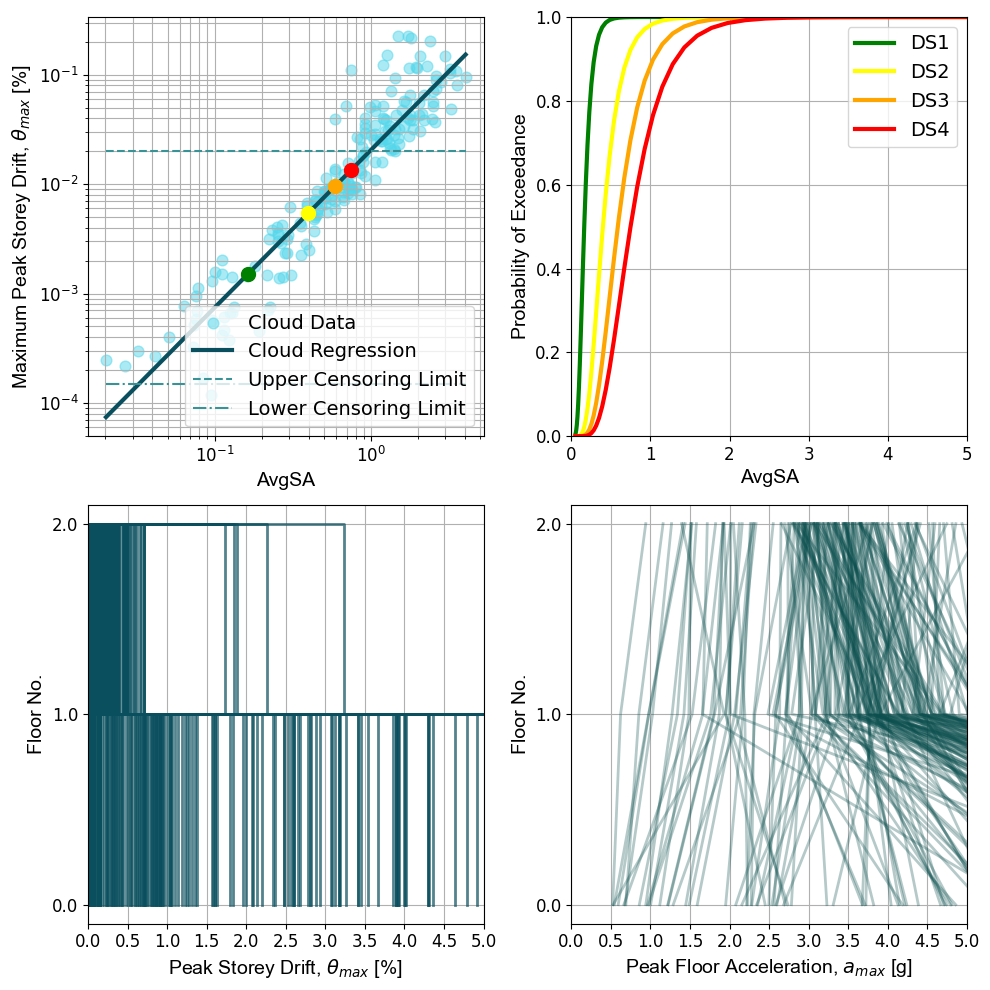

In [8]:
# Initialise the postprocessor class
pp = postprocessor()

# Initialise the plotter class
pl = plotter()

# Loop over the intensity measure types and perform cloud regression to fit the probabilistic seismic demand-capacity model
for _, current_imt in enumerate(IMTs):
    
    # Import the current intensity measure type
    imls = ims[f'{current_imt}']                   

    # Import the engineering demand parameters (i.e., mpsd) from the analysis dictionary (processed from example 2)
    edps = ansys_dict['max_peak_drift_list']  
    
    # Process cloud analysis results using the "do_cloud_analysis" function called from "postprocessor" 
    # The output will be automatically stored in a dictionary
    cloud_dict = pp.do_cloud_analysis(imls,
                                      edps,
                                      damage_thresholds,
                                      lower_limit,
                                      censored_limit) 
        
    ## Visualise the cloud analysis results
    pl.plot_cloud_analysis(cloud_dict, 
                          output_directory = None, 
                          plot_label = f'cloud_analysis_{current_imt}',
                          xlabel = f'{current_imt} [g]', 
                          ylabel = r'Maximum Peak Storey Drift, $\theta_{max}$ [%]') # The y-axis values of drift are converted to % automatically by the plotter

    ## Visualise the fragility functions
    pl.plot_fragility_analysis(cloud_dict,
                               output_directory = None,
                               plot_label = f'fragility_{current_imt}',
                               xlabel = f'{current_imt}')

    ## Visualise the seismic demands
    pl.plot_demand_profiles(ansys_dict['peak_drift_list'], 
                            ansys_dict['peak_accel_list'], 
                            ansys_dict['control_nodes'], 
                            output_directory = None,
                            plot_label="seismic_demand_profiles") # The y-axis values of drift and acceleration are converted to % and g automatically by the plotter
        
    ## Visualise the entire set of results using subplots
    pl.plot_ansys_results(cloud_dict,
                          ansys_dict['peak_drift_list'],
                          ansys_dict['peak_accel_list'],
                          ansys_dict['control_nodes'],
                          output_directory = None,
                          plot_label = f'analysis_output_{current_imt}',
                          cloud_xlabel = f'{current_imt}',
                          cloud_ylabel = r'Maximum Peak Storey Drift, $\theta_{max}$ [%]')

### Cloud Analysis Part 4: Constructing Vulnerability Functions ###

To derive the vulnerability, the consequence model needs to convolved with the fragility functions.  To do so, we can use the "get_vulnerability_function" method from the "postprocessor" class. Setting the uncertainty to True will additionally calculate the coefficient of variation to explicitly consider the uncertainty in the Loss|IM as per Silva et al. (2019)

C:\Users\mnafeh\Documents\GitHub\oq-vmtk\openquake\vmtk\plotter.py:484: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  violin=sns.violinplot(
C:\Users\mnafeh\Documents\GitHub\oq-vmtk\openquake\vmtk\plotter.py:484: FutureWarning: 

The `bw` parameter is deprecated in favor of `bw_method`/`bw_adjust`.
Setting `bw_method=0.2`, but please see docs for the new parameters
and update your code. This will become an error in seaborn v0.15.0.

  violin=sns.violinplot(


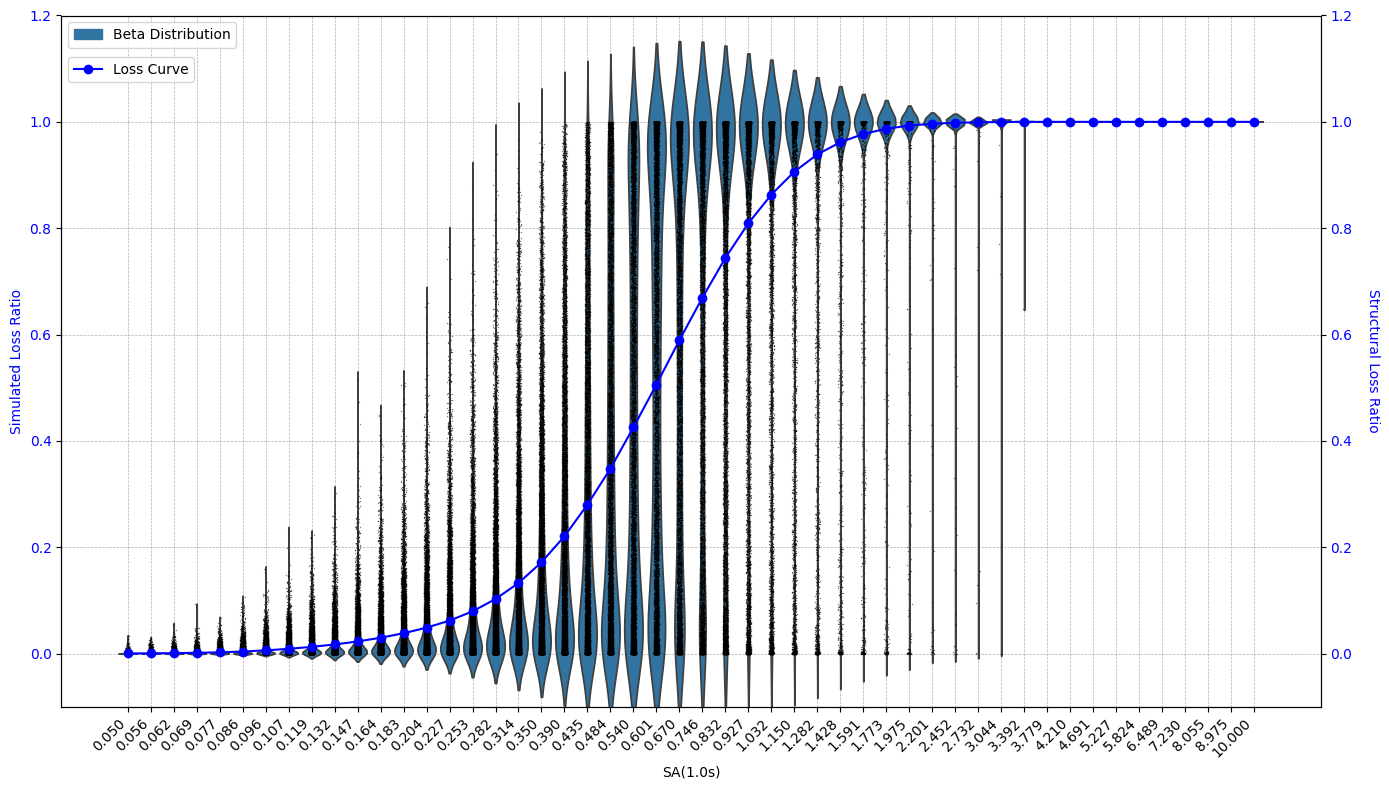

       IML      Loss           COV
0    0.050  0.000195  6.263297e+00
1    0.056  0.000405  4.512630e+00
2    0.062  0.000741  3.519322e+00
3    0.069  0.001331  2.850428e+00
4    0.077  0.002304  2.419865e+00
5    0.086  0.003802  2.148719e+00
6    0.096  0.005956  1.976860e+00
7    0.107  0.008858  1.863840e+00
8    0.119  0.012552  1.784707e+00
9    0.132  0.017037  1.724873e+00
10   0.147  0.022698  1.672874e+00
11   0.164  0.029659  1.625288e+00
12   0.183  0.038163  1.579185e+00
13   0.204  0.048664  1.532013e+00
14   0.227  0.061857  1.481573e+00
15   0.253  0.079351  1.423969e+00
16   0.282  0.102486  1.358209e+00
17   0.314  0.132554  1.284440e+00
18   0.350  0.171655  1.201768e+00
19   0.390  0.220489  1.112718e+00
20   0.435  0.280127  1.018361e+00
21   0.484  0.347872  9.240598e-01
22   0.540  0.425292  8.273997e-01
23   0.601  0.505952  7.347726e-01
24   0.670  0.589275  6.440560e-01
25   0.746  0.669175  5.588036e-01
26   0.832  0.744073  4.776431e-01
27   0.927  0.809193

In [9]:
# In this example, since the latest iteration of the previous cell uses 'AvgSA' as the intensity measure,
# then all variables stored inside the "cloud_dict" dictionary correspond to that same IM. Hence, 
# the vulnerability function derived here will represent the continuous relationship of the expected 
# structural loss ratio conditioned on increasing levels of ground-shaking expressed in terms of the 
# average spectral acceleration (in g)

structural_vulnerability = pp.get_vulnerability_function(cloud_dict['fragility']['poes'],
                                                         consequence_model,
                                                         uncertainty=True)


# Plot the structural vulnerability function
pl.plot_vulnerability_analysis(structural_vulnerability['IML'],
                               structural_vulnerability['Loss'],
                               structural_vulnerability['COV'],
                               'SA(1.0s)',
                               'Structural Loss Ratio',
                               output_directory = None,
                               plot_label = 'Structural Vulnerability')


# The output is a DataFrame with three keys: IMLs (i.e., intensity measure levels), Loss and COV
print(structural_vulnerability)